# Demo de Red Bayesiana para clasificar
Utiliza https://erdogant.github.io/bnlearn/pages/html/index.html para usar Redes Bayesianas

In [1]:
#@title Instalar 'bnlearn' para Redes Bayesianas
# nota: se usa la versión 0.7.12 porque la más nueva es incompatible con numpy
!pip install bnlearn==0.7.12
#!pip install git+https://github.com/erdogant/bnlearn

  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 553.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.8 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=eef25c68b31b891353db2703aa095498dba78d0782cea5d0684c00deabd6a4fe
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
#@title Fuerza reiniciar el entorno
#@markdown Nota: se debe reiniciar el entorno para para aplicar los cambios de dependencias.
import os
import matplotlib
import numpy
print("matplotlib versión: ", matplotlib.__version__)
print("numpy versión: ", numpy.__version__)


# Version matplotlib should be >= 3.3.4
if matplotlib.__version__ < "3.3.4":
  print("La versión de matplotlib debe ser mayor a 3.3.4!!")
  print("--> se reinicia el entorno (esto puede generar un mensaje de error, ignorarlo y seguir ejecutando)")
  #os.kill(os.getpid(), 9)
  exit()

matplotlib versión:  3.7.1
numpy versión:  1.26.4


In [3]:
#@title Librerías a usar

import bnlearn as bn

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

import os
import csv

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [4]:
#@title Acceder al Drive

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [5]:
#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global df, nombre_clases, atributo_entrada, atributo_clase

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # define atributo clase
  atributo_clase = attClase
  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return
  atributo_entrada = list(att_entrada)
  if atributo_clase not in att_entrada:
    att_entrada.append(attClase)

  # guarda configuración
  nombre_clases = nomClases

  # genera los datos solo con los atributos seleccionados
  df = df_ori[att_entrada]

  # muestra resultados
  print("\n", df.head())

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")


## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df_ori = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df_ori.head())
print("\n> Características: ")
print(df_ori.describe())
print("\n")

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df_ori.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…



    LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]


In [6]:
#@title Preparar Datos - Discretizar
tipo_discretizacion = "Mismo Ancho - Uniform" #@param ["Mismo Ancho - Uniform", "Misma Cantidad - Quantile", "Clustered"]
cant_valores_discretizacion = 5 #@param {type:"integer"}
eliminar_datos_no_numericos = True #@param {type:"boolean"}

# hace una copia para trabajar
ndf = df.copy(True)
clases_map = nombre_clases.split(",")

print("> Datos antes a discretizar: ")
print(ndf.head())
print(ndf.describe())
print("")

from sklearn.preprocessing import KBinsDiscretizer

if cant_valores_discretizacion < 2:
  cant_valores_discretizacion = 2

# elegir el método de normalización
if tipo_discretizacion == "Mismo Ancho - Uniform":
  kbins = KBinsDiscretizer(n_bins=cant_valores_discretizacion, encode='ordinal', strategy='uniform')
elif tipo_discretizacion == "Misma Cantidad - Quantile":
  kbins = KBinsDiscretizer(n_bins=cant_valores_discretizacion, encode='ordinal', strategy='quantile')
elif tipo_discretizacion == "Clustered":
  kbins = KBinsDiscretizer(n_bins=cant_valores_discretizacion, encode='ordinal', strategy='kmeans')

# aplica la normalización sólo en columnas de datos
col = atributo_clase
for col in ndf.columns.values.tolist():
  if ndf[col].dtypes == "object":
    if eliminar_datos_no_numericos:
       # elimina la columna
       print("-- Se elimina columna:", col)
       ndf = ndf.drop(columns=[col])
  else:
    if (atributo_clase != "") and (col==atributo_clase) and (len(nombre_clases)>0):
      # si es el atributo clase y se conocen los nombres los usa
      print("-- Se asigna nombres a columna:", col)
      ndf[col] = [ clases_map[v] for v in ndf[col] ]
    else:
      # sino genera rango y le asigna nombre genérico
      print("-- Se discretiza con ", cant_valores_discretizacion," rangos a la columna:", col)
      ndf[col] = kbins.fit_transform( ndf[col].values.reshape(-1, 1) )
      ndf[col] = ndf[col].astype(int)
      ndf[col] = ndf[col] + 1
      ndf[col] = 'rango_' + ndf[col].astype(str)

print("\n\n> Datos luego de discretizar: ")
print(ndf.head())
print(ndf.describe())
print("\n")


> Datos antes a discretizar: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max       7.900000     4.400000     6.900000

In [7]:
#@title Preparar Datos  - Separar Entrenamiento / Prueba

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   80#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# separa al azar usando muestreo con proporción indicada
# intenta hacer muestreo estatificado
try:
  ndf_train, ndf_test = train_test_split(ndf, test_size=(1-propTrain), stratify=ndf[atributo_clase], shuffle=True)
except ValueError:
  print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
  # hace muestreo simple
  ndf_train, ndf_test = train_test_split(ndf, test_size=(1-propTrain), shuffle=True)

print("\n> Para Entrenamiento: ")
print(" - ndf_train (cant ejemplos): ", len(ndf_train))
print("\n Para Prueba: ")
print(" - ndf_test (cant ejemplos): ", len(ndf_test))



> Para Entrenamiento: 
 - ndf_train (cant ejemplos):  120

 Para Prueba: 
 - ndf_test (cant ejemplos):  30


# Modelo:


--Preparando datos de entrenamiento.

[df2onehot] >Auto detecting dtypes.


100%|██████████| 5/5 [00:00<00:00, 56.16it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████| 5/5 [00:00<00:00, 44.41it/s]


[df2onehot] >Total onehot features: 18

-- Determina estructura de la red en base a los datos.
[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/10.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores ['k2', 'bds', 'bic', 'bdeu'] for model comparison (higher is better).

-- Determina probabilidades de la red en base a los datos.
[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of LargoSepalo:
+----------------------+---------------+-------------------+------------------+
| Clase                | Clase(Setosa) | Clase(Versicolor) | Clase(Virginica) |
+----------------------+---------------+-------------------+------------------+
| LargoSepalo(rango_1) | 0.525         | 0.05              | 0.025            |
+----------------------+---------------+-------------------+------------------+
| LargoSepalo(rango_2) | 0.45          | 0.425             | 0.025            |
+----------------------+---------------+-------------------+------------------+
| LargoSepalo(rango_3) | 0.025         | 0.4        

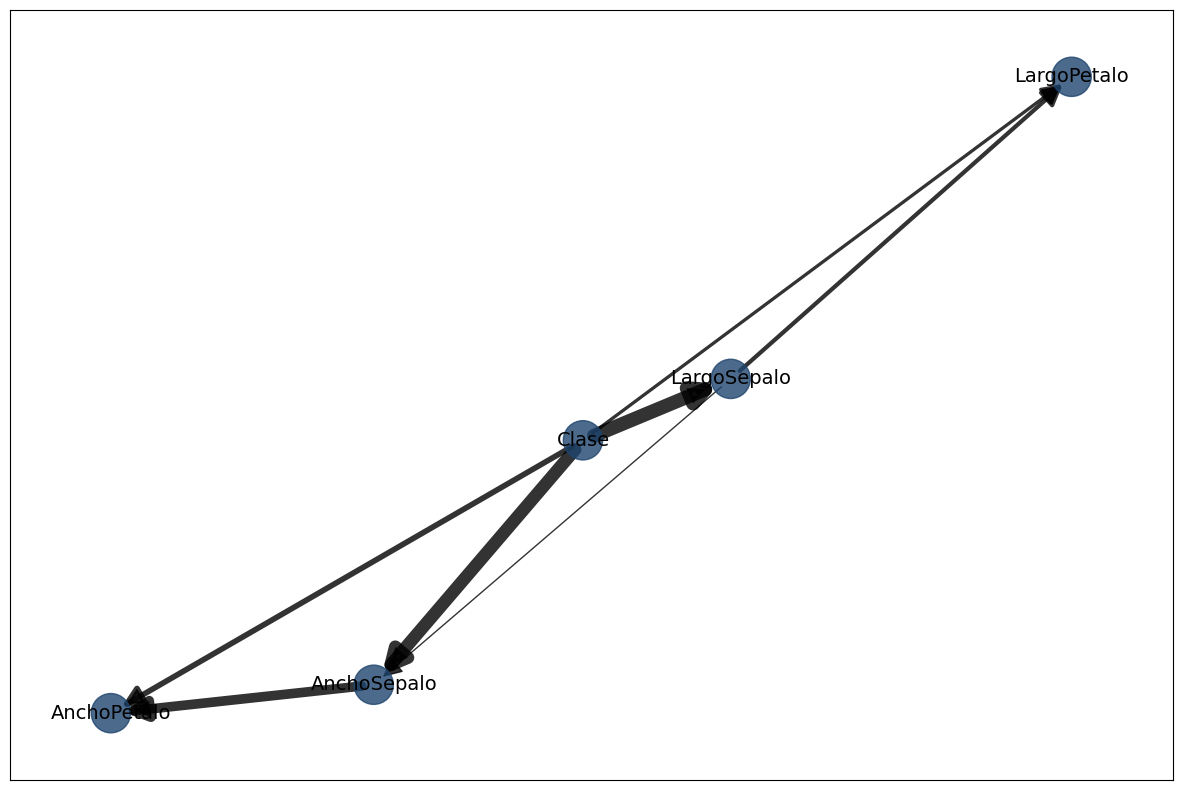

In [8]:
#@title Establecer y entrenar modelo Red Bayesiana

#@markdown Parámetros para aprender estructura de la red:
metodo_busq_para_aprender_estructura = "Tree-augmented Naive Bayes" #@param [ "Naive Bayes", "Tree-augmented Naive Bayes", "Hill Climb Search", "Exhaustive Search", "Constraint Search", "Chow-Liu" ]

#@markdown Parámetros para aprender probabilidades de la red:
metodo_busq_para_aprender_probabilidades = "Maximum Likelihood Estimation" #@param [ "Bayesian Estimation", "Maximum Likelihood Estimation" ]

#@markdown Parámetros para ambos aprendizajes:
tipo_score_aprender = "K2 score" #@param [ "BIC score", "BDeu score", "K2 score" ]

if tipo_score_aprender == "K2 score":
    scoreType = "k2"
if tipo_score_aprender == "BDeu score":
    scoreType = "bdeu"
else:
  #if tipo_score_aprender == "BIC score":
    scoreType = "bic"


print("\n--Preparando datos de entrenamiento.")
dfhot, dfnum = bn.df2onehot(ndf_train)

print("\n-- Determina estructura de la red en base a los datos.")
root_node = None
class_node = None
if metodo_busq_para_aprender_estructura == "Hill Climb Search":
  metApEstr = "hillclimbsearch"
elif metodo_busq_para_aprender_estructura == "Exhaustive Search":
  metApEstr = "exhaustivesearch"
elif metodo_busq_para_aprender_estructura == "Constraint Search":
  metApEstr = "constraintsearch"
elif metodo_busq_para_aprender_estructura == "Chow-Liu":
  # se define root node
  root_node = atributo_clase
  metApEstr = "chow-liu"
elif metodo_busq_para_aprender_estructura == "Naive Bayes":
  # se define root node
  root_node = atributo_clase
  metApEstr = "naivebayes"
else:
#elif metodo_busq_para_aprender_estructura == "Tree-augmented Naive Bayes":
  # se define root node y class node
  class_node = atributo_clase
  for root_node in ndf.columns.values.tolist():
    # busca un nodo diferente a class node
    if class_node != root_node:
      break
  metApEstr = "tan"

# hace el aprendizaje de estructura
modelRB = bn.structure_learning.fit(dfnum,
                                    methodtype=metApEstr,
                                    scoretype=scoreType,
                                    root_node=root_node, class_node=class_node)


print("\n-- Determina probabilidades de la red en base a los datos.")
if metodo_busq_para_aprender_probabilidades == "Bayesian Estimation":
  metApProbab = "bayes"
else:
  # "Maximum Likelihood Estimation" ]
  metApProbab = "ml"

# hace el aprendizaje de probabilidades
modelRB = bn.parameter_learning.fit(modelRB,
                                    ndf_train,
                                    methodtype=metApProbab)
# muestra probabilidades
print(modelRB['adjmat'])
print("")

print("\n-- Grafica modelo:")

# Compute edge strength using chi-square independence test
modelRB = bn.independence_test(modelRB, ndf_train)
print(modelRB['independence_test'])

# Plot based on structure learning of sampled data
graph = bn.plot(modelRB)

# comprobar modelo
#CPDs = bn.print_CPD(modelRB, checkmodel=True)

In [9]:
#@title Mostrar Red Bayesiana en forma interactiva
graph = bn.plot(modelRB,
            interactive=True,
            params_interactive={'notebook':True, 'cdn_resources': 'remote'})


[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
bnlearn_causal_network.html


*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        40
  Versicolor       0.97      0.95      0.96        40
   Virginica       0.95      0.97      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120


Matriz de Confusión ( real / modelo ): 
              m:Setosa  m:Versicolor  m:Virginica
r:Setosa            40             0            0
r:Versicolor         0            38            2
r:Virginica          0             1           39




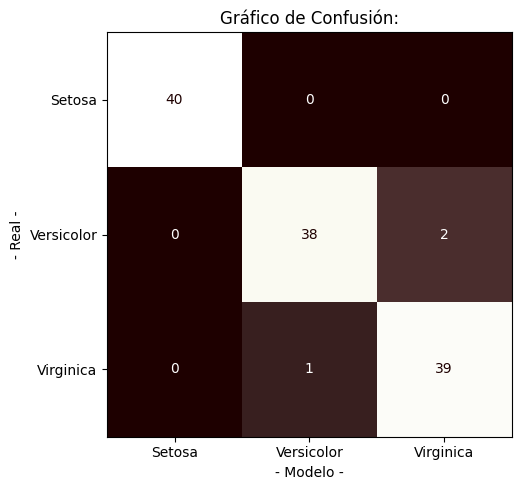

In [13]:
#@title Evaluar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}


def probarRedBayesiana(y_atributoNombre, y_clases_map, x_evideDicList, y_infResList, mostrarDetalle=False, inclDatosEntrada=False):

  if mostrarDetalle:
    if inclDatosEntrada:
      print("  Datos Entrada -> Clase Real / Clase Modelo [resultado]")
    else:
      print(" Clase Real / Clase Modelo [resultado]")

  # inicializa listas
  classReal = []
  classPreds = []
  for xEv, clReal in zip(x_evideDicList, y_infResList):
      # ejecuta la red bayesiana para que haga la inferencia
      resRB = bn.inference.fit(modelRB, variables=[y_atributoNombre], evidence=xEv, verbose=1)
      # determina resultdo ID con mayor probabilidad
      id_maxProb = int( np.argmax(resRB.values, axis=0) )
      clPred = resRB.state_names[y_atributoNombre][id_maxProb]
      # registra los resultados
      classReal.append( clReal )
      classPreds.append( clPred )

      # muestra comparación con la imagen
      if mostrarDetalle:
        print("")
        if inclDatosEntrada:
          print(" Evidencia: ", xEv)
        strTitulo = '  -> R: ' + str(clReal) +' / M: ' + str(clPred)
        strTitulo = strTitulo + " [ " + ("OK" if (clPred==clReal) else "ERROR!") + " ]"
        print(strTitulo)
        print(resRB)

  # genera lista de labels
  labels_clases_map =  list(set(classReal + classPreds))
  labels_clases_map.sort()

  # muestra reporte de clasificación
  print("\n Reporte de Clasificación: ")
  print(classification_report(classReal, classPreds, zero_division=0))

  # muestra matriz de confusion
  print('\nMatriz de Confusión ( real / modelo ): ')
  cm = confusion_matrix(classReal, classPreds, labels=labels_clases_map)
  cmtx = pd.DataFrame(
      cm,
      index=['r:{:}'.format(x) for x in labels_clases_map],
      columns=['m:{:}'.format(x) for x in labels_clases_map]
    )
  # agrega para poder mostrar la matrix de confusión completa
  pd.options.display.max_rows = 100
  pd.options.display.max_columns = 100
  #cmtx.sort_index(axis=0, inplace=True)
  #cmtx.sort_index(axis=1, inplace=True)
  print(cmtx)
  print("\n")

  # gráfico de comparación
  dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_clases_map)
  fig, ax = plt.subplots(figsize=(15,5))
  dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
  dispCM.ax_.set_title('Gráfico de Confusión:')
  dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
  plt.tight_layout()
  plt.show()

def prepararDatosInfRB(ndf, atributo_clase):
  # prepara datos para hacer inferencia
  # determina atributos
  att_entrada = ndf.columns.values.tolist()
  att_entrada.remove( atributo_clase )
  # prepara listas con datos
  y_infResList = np.array(ndf[atributo_clase])
  x_evideDicList = []
  for xRow in np.array(ndf[att_entrada]):
    auxDict = {}
    for col, xV in zip(att_entrada,xRow):
      auxDict[col] = xV
    x_evideDicList.append( auxDict )
  return x_evideDicList, y_infResList

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
# prepara datos
x_evideDicList, y_infResList = prepararDatosInfRB(ndf_train, atributo_clase)
# prueba red bayesiana
probarRedBayesiana(atributo_clase, clases_map, x_evideDicList, y_infResList, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)



*** Resultados con datos de Prueba: 
  Datos Entrada -> Clase Real / Clase Modelo [resultado]

 Evidencia:  {'LargoSepalo': 'rango_2', 'AnchoSepalo': 'rango_4', 'LargoPetalo': 'rango_1', 'AnchoPetalo': 'rango_1'}
  -> R: Setosa / M: Setosa [ OK ]
+-------------------+--------------+
| Clase             |   phi(Clase) |
+===================+==============+
| Clase(Setosa)     |       1.0000 |
+-------------------+--------------+
| Clase(Versicolor) |       0.0000 |
+-------------------+--------------+
| Clase(Virginica)  |       0.0000 |
+-------------------+--------------+

 Evidencia:  {'LargoSepalo': 'rango_3', 'AnchoSepalo': 'rango_2', 'LargoPetalo': 'rango_4', 'AnchoPetalo': 'rango_4'}
  -> R: Virginica / M: Virginica [ OK ]
+-------------------+--------------+
| Clase             |   phi(Clase) |
+===================+==============+
| Clase(Setosa)     |       0.0000 |
+-------------------+--------------+
| Clase(Versicolor) |       0.0000 |
+-------------------+--------------+


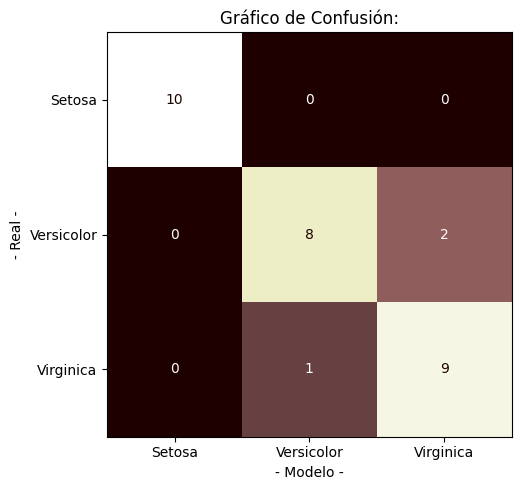

In [14]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = True #@param {type:"boolean"}


# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
# prepara datos
x_evideDicList, y_infResList = prepararDatosInfRB(ndf_test, atributo_clase)
# prueba red bayesiana
probarRedBayesiana(atributo_clase, clases_map, x_evideDicList, y_infResList, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)

In [15]:
#@title Guardar Modelo

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/datosRBay'  #@param {type:"string"}

if guardar_modelo:

    import joblib
    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_modelo = path_modelo + "/RB.joblib"
    joblib.dump(modelRB, fn_modelo)
    print("\n-Red Bayesiana guardado en ", fn_modelo,"\n")


    fn_kbins = path_modelo + "/KBINS.joblib"
    joblib.dump(kbins, fn_kbins)
    print("\n-Función para discretizar datos guardada en ", fn_kbins,"\n")

    fn_prepDatos = path_modelo + "/FUNC_PREP_DATOS.joblib"
    joblib.dump(prepararDatosInfRB, fn_prepDatos)
    print("\n-Función para preparar datos guardada en ", fn_prepDatos,"\n")


else:
    print("\n-Modelo no guardado.")


-Red Bayesiana guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/datosRBay/RB.joblib 


-Función para discretizar datos guardada en  /content/gdrive/MyDrive/IA/demoML/modelos/datosRBay/KBINS.joblib 


-Función para preparar datos guardada en  /content/gdrive/MyDrive/IA/demoML/modelos/datosRBay/FUNC_PREP_DATOS.joblib 

